In [1]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [2]:
data_path = r"C:\Users\Reljod\Desktop\Study Materials\kaggle\dataset\titanic"

In [3]:
train_path = os.path.join(data_path, "train.csv")
test_path = os.path.join(data_path, "test.csv")
submission_path = os.path.join(data_path, "gender_submission.csv")

## Checking data

In [4]:
train_raw = pd.read_csv(train_path)

In [5]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_raw.shape

(891, 12)

##### Thoughts
The training data only has <b>891 instances</b>, a miniscule number of data.<br>
The data also have <b>12 features</b>, one as a target feature.<br>


### Make sure to study the features

**pclass**: A proxy for socio-economic status (SES)<br>
> - 1 = Upper <br>
> - 2 = Middle <br>
> - 3 = Lower <br>

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 <br>

**sibsp**: # of siblings / spouses aboard the Titanic <br> 
 >The dataset defines family relations in this way... <br>
 - Sibling = brother, sister, stepbrother, stepsister <br>
 - Spouse = husband, wife (mistresses and fiancés were ignored) <br>

**parch**:  # of parents / children aboard the Titanic <br>
 >The dataset defines family relations in this way... <br>
 - Parent = mother, father <br>
 - Child = daughter, son, stepdaughter, stepson <br>
 - Some children travelled only with a nanny, therefore parch=0 for them. <br>

**ticket**:	Ticket number	

**fare**:	Passenger fare	

**cabin**:	Cabin number

**embarked**: Port of Embarkation <br>
> - C = Cherbourg <br>
> - Q = Queenstown <br>
> - S = Southampton <br>

In [7]:
# Make a copy, it is always advisable to save a copy of the raw train data
df = train_raw.copy()

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
df.set_index('PassengerId', inplace=True)

In [10]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Observing the relationship of features to survivability
 - One way of doing this is by **graphing**.

In [11]:
# Setting the plotting style into seaborn style
sns.set()

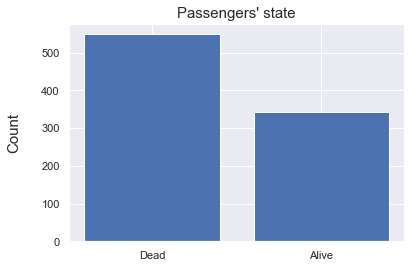

In [12]:
target = df["Survived"]
x_surv = target.value_counts().keys()
y_surv = target.value_counts()
_ = plt.bar(x_surv, y_surv, tick_label=["Dead","Alive"])
_ = plt.title("Passengers' state", {'fontsize': 15})
_ = plt.ylabel("Count", {'fontsize': 15}, labelpad=20)
_ = plt.show()

#### Comment
The training data contains less survived passengers <br>
Let's see if this **imbalanced** will affect our model's prediction later.

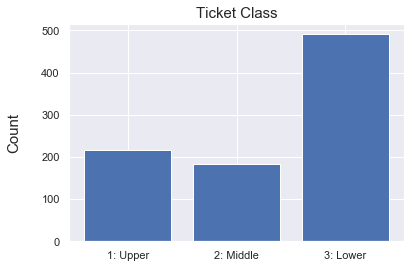

In [13]:
pclass = df["Pclass"]
x_pclass = pclass.value_counts().keys()
y_pclass = pclass.value_counts()
_ = plt.bar(x_pclass, y_pclass, tick_label=['3: Lower', '1: Upper', '2: Middle',])
_ = plt.title("Ticket Class", {'fontsize': 15})
_ = plt.ylabel("Count", {'fontsize': 15}, labelpad=20)
_ = plt.show()

#### Comment
 - There's a lot more lower class than any other classes
 - We can hypothesize that the high frequency of dead passengers are because of the high frequency of lower class tickets. Let's invistigate it further

In [14]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [15]:
df.mean()

Survived     0.383838
Pclass       2.308642
Age         29.699118
SibSp        0.523008
Parch        0.381594
Fare        32.204208
dtype: float64

In [16]:
df.mode(numeric_only=True).transpose()

,0
Survived,0.00
Pclass,3.00
Age,24.00
SibSp,0.00
Parch,0.00
Fare,8.05


In [17]:
df.std()

Survived     0.486592
Pclass       0.836071
Age         14.526497
SibSp        1.102743
Parch        0.806057
Fare        49.693429
dtype: float64

In [18]:
df.var()

Survived       0.236772
Pclass         0.699015
Age          211.019125
SibSp          1.216043
Parch          0.649728
Fare        2469.436846
dtype: float64

### Cleaning the data

In [19]:
datainfo = df.info()
print(datainfo)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


##### Comment

 1. There's clearly a null value that we must get rid of
 2. We must convert all non-numeric values to numeric before we feed it to the model
 3. Also, we must do a slight feature engineering to this

### Removing Null Values

 + **Cabin has only 204 nun-null values** and its null values can affect our prediction. It is my decision to just remove the whole feature because filling the null values might lead as to a inaccurate prediction. Furthermore, you wont be able to drop rows also because it will affect the number of training samples. Therefore, my say is to just **drop the whole column.**

In [20]:
df.drop(["Cabin"], axis=1, inplace=True)

In [21]:
## Checking if the cabin column is gone...
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [22]:
print(df.Age.describe())
### Looking at the description, we can see that the there's a variety of age groups looking at the std, there's an infant, 
### a senior but most of them lies between 20 to 38 years old age group. The median and the mean also doesn't differ much
### at 28.5.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


##### Comment in Age column
Looking at the description, I decided that I will just fill the nan values into the median of the age column.

In [23]:
df["Age"].fillna(df.Age.median(), inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [25]:
print(df["Embarked"].value_counts())
print(df["Embarked"].unique())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
['S' 'C' 'Q' nan]


 - As we can see in the info, there are two missing values in the **Embarked** column and we can choose two ways. One is to just *remove the entire row where there is a missing value* and two, just *fill it with a value* that is mean value or a mode value.
 - I chose dropping the entire row because removing just two rows is insignificant.

In [26]:
### Removing the rows with nan-values
df.dropna(inplace=True)

In [27]:
## Checking again, it seems there is no null values anymore!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB


### Converting Object data to numerical data

In [28]:
df_obj = df.select_dtypes(['object']).copy()

In [29]:
df_obj.drop(["Name", "Ticket"], axis=1, inplace=True)

In [30]:
df_obj.tail()

,Sex,Embarked
PassengerId,,
887,male,S
888,female,S
889,female,S
890,male,C
891,male,Q


In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Converting Sex feature to One hot Encoding

In [32]:
le = LabelEncoder()
df_le = le.fit_transform(df_obj["Sex"]) #male = 1, female = 0

In [33]:
ohe = OneHotEncoder(categories='auto')
df_ohe = ohe.fit_transform(df_obj["Sex"].values.reshape(-1,1))

In [34]:
sex_cols = list(ohe.categories_[0])

In [35]:
df_ohe_sex = pd.DataFrame(df_ohe.toarray(), columns=sex_cols, dtype=np.int)

In [36]:
df_ohe_sex.set_index(df_obj.index, inplace=True)

In [37]:
df_ohe_sex.head()

,female,male
PassengerId,,
1,0,1
2,1,0
3,1,0
4,1,0
5,0,1


### Converting Embarked Feature to One hot Encoding

In [38]:
ohe_emb = ohe.fit_transform(df_obj["Embarked"].values.reshape(-1,1))

In [39]:
emb_cols = list(ohe.categories_[0])
print(emb_cols)

['C', 'Q', 'S']


In [40]:
df_ohe_emb = pd.DataFrame(ohe_emb.toarray(), columns=emb_cols, dtype=np.int)

In [41]:
df_ohe_emb.set_index(df_obj.index, inplace=True)

In [42]:
df_ohe_emb.head()

,C,Q,S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1


### Joining the New Features into the original dataframe

In [43]:
df1 = df.copy()

In [44]:
target = df1.pop("Survived")

In [45]:
df1.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [46]:
### Dropping some columns
df1.drop(["Name", "Sex", "Ticket", "Embarked"], axis=1, inplace=True)

In [47]:
### Adding the one hot encoded columns
df_ohe = pd.concat([df1, df_ohe_sex, df_ohe_emb], axis=1)

In [48]:
df_ohe.head(10)

,Pclass,Age,SibSp,Parch,Fare,female,male,C,Q,S
PassengerId,,,,,,,,,,
1,3,22.0,1,0,7.2500,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,1,0,0
3,3,26.0,0,0,7.9250,1,0,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,0,1
5,3,35.0,0,0,8.0500,0,1,0,0,1
6,3,28.0,0,0,8.4583,0,1,0,1,0
7,1,54.0,0,0,51.8625,0,1,0,0,1
8,3,2.0,3,1,21.0750,0,1,0,0,1
9,3,27.0,0,2,11.1333,1,0,0,0,1


### Convert Other Ordinal data to Categorical data

In [49]:
df_ohe.Pclass.value_counts()

3    491
1    214
2    184
Name: Pclass, dtype: int64

In [50]:
ohe = OneHotEncoder(categories="auto")
ohe_pclass = ohe.fit_transform(df_ohe.Pclass.values.reshape(-1,1))

In [51]:
pclass_cols = list(ohe.categories_[0])
#print(pclass_cols)
pclass_names = ["upper", "middle", "lower"]
pclass_dict = dict(zip(pclass_names, pclass_cols))
print(pclass_dict)
print(pclass_dict.keys())

{'upper': 1, 'middle': 2, 'lower': 3}
dict_keys(['upper', 'middle', 'lower'])


In [52]:
ohe_pclass.toarray()

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [53]:
df_pclass_ohe = pd.DataFrame(ohe_pclass.toarray(), index=df.index, columns=pclass_dict.keys(), dtype=np.int)
df_pclass_ohe.head()

,upper,middle,lower
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,1,0,0
5,0,0,1


In [54]:
df_ohe.SibSp.value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [55]:
df_ohe.Parch.value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

### Changing the SibSp and Parch feature
>**SibSp**
 - We will split it into only two categories: ***NoSibSp*** and ***HasSibSp***
 
>**Parch**
- We will also split it into only two categories: ***NoParch*** and ***HasParch***

In [56]:
df_ohe.Parch.head()

PassengerId
1    0
2    0
3    0
4    0
5    0
Name: Parch, dtype: int64

In [57]:
new_SibSp = df_ohe.SibSp.apply(lambda x: 'NoSibSp' if x==0 else 'HasSibSp')

In [58]:
new_Parch = df_ohe.Parch.apply(lambda x: 'NoParch' if x==0 else 'HasParch')

In [59]:
new_SibSp.value_counts()

NoSibSp     606
HasSibSp    283
Name: SibSp, dtype: int64

In [60]:
new_Parch.value_counts()

NoParch     676
HasParch    213
Name: Parch, dtype: int64

### Converting SibSp and Parch to One Hot Encoding

In [61]:
ohe_sibsp = ohe.fit_transform(new_SibSp.values.reshape(-1,1))
ohe.categories_

[array(['HasSibSp', 'NoSibSp'], dtype=object)]

In [62]:
sibsp_cols = list(ohe.categories_[0])
print(sibsp_cols)

['HasSibSp', 'NoSibSp']


In [63]:
ohe_parch = ohe.fit_transform(new_Parch.values.reshape(-1,1))
ohe.categories_

[array(['HasParch', 'NoParch'], dtype=object)]

In [64]:
parch_cols = list(ohe.categories_[0])
print(parch_cols)

['HasParch', 'NoParch']


In [65]:
df_sibsp_ohe = pd.DataFrame(ohe_sibsp.toarray(), columns=sibsp_cols, index=df.index, dtype=np.int)
df_sibsp_ohe.head(10)

,HasSibSp,NoSibSp
PassengerId,,
1,1,0
2,1,0
3,0,1
4,1,0
5,0,1
6,0,1
7,0,1
8,1,0
9,0,1


In [66]:
df_parch_ohe = pd.DataFrame(ohe_parch.toarray(), columns=parch_cols, index=df.index, dtype=np.int)
df_parch_ohe.head(10)

,HasParch,NoParch
PassengerId,,
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,1,0
9,1,0


### Joining the Pclass, SibSp, and Parch One Hot Encoded features

In [67]:
df_ohe.drop(["Pclass"], axis=1, inplace=True)

In [68]:
df_num = pd.concat([df_ohe, df_pclass_ohe, df_sibsp_ohe, df_parch_ohe], axis=1)

In [69]:
df_num.values

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  1.,  0.],
       [26.,  0.,  0., ...,  1.,  0.,  1.],
       [32.,  0.,  0., ...,  1.,  0.,  1.]])

### Splitting the dataset for training

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_num, target, test_size=0.3, random_state=10)

In [71]:
X_train.head()

,Age,SibSp,Parch,Fare,female,male,C,Q,S,upper,middle,lower,HasSibSp,NoSibSp,HasParch,NoParch
PassengerId,,,,,,,,,,,,,,,,
8,2.0,3,1,21.075,0,1,0,0,1,0,0,1,1,0,1,0
417,34.0,1,1,32.500,1,0,0,0,1,0,1,0,1,0,1,0
304,28.0,0,0,12.350,1,0,0,1,0,0,1,0,0,1,0,1
736,28.5,0,0,16.100,0,1,0,0,1,0,0,1,0,1,0,1
185,4.0,0,2,22.025,1,0,0,0,1,0,0,1,0,1,1,0


In [72]:
print("Train data: ", X_train.shape)
print("Train label: ", y_train.shape)
print("Test data: ", X_test.shape)
print("Test label: ", y_test.shape)

Train data:  (622, 16)
Train label:  (622,)
Test data:  (267, 16)
Test label:  (267,)


In [73]:
y_train.head()

PassengerId
8      0
417    1
304    1
736    0
185    1
Name: Survived, dtype: int64

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rfc = RandomForestClassifier(n_estimators=200,
                            max_depth=40,
                            random_state=10, min_samples_leaf=1, n_jobs=-1)

In [76]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [77]:
y_pred = rfc.predict(X_test)

In [78]:
y_pred_train = rfc.predict(X_train)

In [79]:
accuracy_score(y_train, y_pred_train)

0.9807073954983923

In [80]:
accuracy_score(y_test, y_pred)

0.7902621722846442

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
lr = LogisticRegression(max_iter= 1000, random_state=10, solver='lbfgs', n_jobs=-1)

In [83]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=10, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [84]:
y_pred_lr = lr.predict(X_test)
y_pred_lr_train = lr.predict(X_train)

In [85]:
accuracy_score(y_train, y_pred_lr_train)

0.8118971061093248

In [86]:
accuracy_score(y_test, y_pred_lr)

0.8164794007490637

In [89]:
df[df["Survived"]==1]["Fare"]

PassengerId
2       71.2833
3        7.9250
4       53.1000
9       11.1333
10      30.0708
11      16.7000
12      26.5500
16      16.0000
18      13.0000
20       7.2250
22      13.0000
23       8.0292
24      35.5000
26      31.3875
29       7.8792
32     146.5208
33       7.7500
37       7.2292
40      11.2417
44      41.5792
45       7.8792
48       7.7500
53      76.7292
54      26.0000
56      35.5000
57      10.5000
59      27.7500
66      15.2458
67      10.5000
69       7.9250
         ...   
805      6.9750
810     53.1000
821     93.5000
822      8.6625
824     12.4750
828     37.0042
829      7.7500
831     14.4542
832     18.7500
836     83.1583
839     56.4958
840     29.7000
843     31.0000
850     89.1042
854     39.4000
856      9.3500
857    164.8667
858     26.5500
859     19.2583
863     25.9292
866     13.0000
867     13.8583
870     11.1333
872     52.5542
875     24.0000
876      7.2250
880     83.1583
881     26.0000
888     30.0000
890     30.0000
Name: Fare, 

In [94]:
RandomForestClassifier().__class__.__name__

'RandomForestClassifier'